## Deep Kernel Learning

We now briefly discuss deep kernel learning. Quoting the [deep kernel learning paper](https://arxiv.org/abs/1511.02222): scalable deep kernels combine the structural properties of deep learning architectures with the non-parametric flexibility of kernel methods. 

We will transform our input via a neural network and feed the transformed input to our GP. To illustrate, we will create a simple step function dataset (heavily inspired from this [excellent writeup on tinyGP](https://tinygp.readthedocs.io/en/stable/tutorials/transforms.html)). We will be comparing our deep kernel with the RBF kernel.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyro.contrib.gp as gp
import pyro

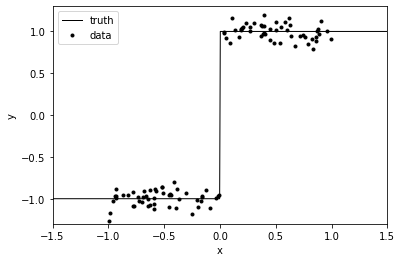

In [2]:
torch.manual_seed(0)

noise = 0.1

x = torch.sort(torch.distributions.Uniform(low=-1., high=1.).sample([100, 1]), 0)[0]
x_squeeze = x.squeeze()
y = 2 * (x_squeeze > 0) - 1 + torch.distributions.Normal(loc=0.0, scale=noise).sample([len(x)])
t =torch.linspace(-1.5, 1.5, 500)

plt.plot(t, 2 * (t > 0) - 1, "k", lw=1, label="truth")
plt.plot(x_squeeze, y, ".k", label="data")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
pyro.clear_param_store()
n = Net()
# Using a separate lengthscale for each dimension
rbf = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))
deep_kernel = gp.kernels.Warping(rbf, iwarping_fn=n)
likelihood = gp.likelihoods.Gaussian()
model_deep = gp.models.VariationalGP(
    X=x,
    y=y,
    kernel=deep_kernel,
    likelihood=likelihood,
    whiten=True,
    jitter=2e-3,
)

model_rbf = gp.models.VariationalGP(
    X=x,
    y=y,
    kernel=gp.kernels.RBF(input_dim=1),
    likelihood=likelihood,
    whiten=True,
    jitter=2e-3,
)

As we can see, it is fairly straightforward to create a `deep` kernel by combining a regular kernel with a neural network. We can also confirm our `deep` kernel by printing it below. It should also be noted that unlike our earlier code, we explicitly specified lengthscale in our above example to be a vector of two values. This will allow our model to learn a different lengthscale for each dimension. 

In [5]:
deep_kernel

Warping(
  (kern): RBF()
  (iwarping_fn): Net(
    (fc1): Linear(in_features=1, out_features=5, bias=True)
    (fc2): Linear(in_features=5, out_features=5, bias=True)
    (fc3): Linear(in_features=5, out_features=2, bias=True)
  )
)

Text(0, 0.5, 'Loss')

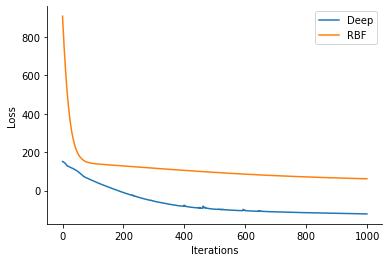

In [6]:
losses_deep = gp.util.train(model_deep, num_steps=1000)
losses_rbf = gp.util.train(model_rbf, num_steps=1000)
plt.plot(losses_deep, label='Deep')
plt.plot(losses_rbf, label='RBF')
sns.despine()
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")

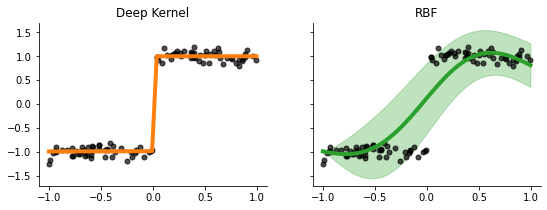

In [7]:
with torch.no_grad():
    fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(9, 3))
    for i, (model_name, model) in enumerate(zip(["Deep Kernel", "RBF"], [model_deep, model_rbf])):
        mean, var = model(x)
        ax[i].plot(x.squeeze(), mean, lw=4, color=f'C{i+1}', label=model_name)
        ax[i].fill_between(x_squeeze, mean-torch.sqrt(var), mean+torch.sqrt(var), alpha=0.3, color=f'C{i+1}')
        ax[i].scatter(x.squeeze(), y, color='k', alpha=0.7, s=25)
        ax[i].set_title(model_name)
sns.despine()

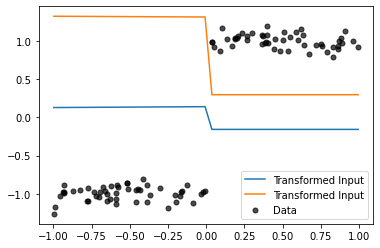

In [8]:
with torch.no_grad():
    z = n(x)
    plt.plot(x.squeeze(), z, label='Transformed Input')
    plt.scatter(x.squeeze(), y, color='k', alpha=0.7, s=25, label='Data')
    plt.legend()

Our deep kernel transform the data into a step function like data, thus, making it better suited in comparison to the RBF kernel, which has a hard time owing to the sudden jump around x=0.0.

In [9]:
rbf.lengthscale

tensor([0.7100, 0.3202], grad_fn=<AddBackward0>)

Finally, we can confirm from the above code that we learn a different lengthscale corresponding to the two dimensions (transformation of the 1 dimensional data by the neural network).